In [ ]:
!pip -q install datasets torchaudio torch torchvision scikit-learn transformers accelerate --upgrade
!pip install torchcodec
!pip install datasets audiomentations

In [ ]:
import numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchaudio.transforms as T
from datasets import load_dataset, Audio
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm
from transformers import AutoProcessor, AutoModelForAudioClassification, TrainingArguments, Trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
SR = 16000


Device: cuda


In [ ]:
ds = load_dataset("danavery/urbansound8K")
ds = ds.cast_column("audio", Audio(sampling_rate=SR, decode=True))

def by_fold(d, folds): return d.filter(lambda ex: ex["fold"] in folds)
train_raw = by_fold(ds["train"], list(range(1,9)))   # 1..8
valid_raw = by_fold(ds["train"], [9])                # 9
test_raw  = by_fold(ds["train"], [10])               # 10

labels = sorted(list(set(train_raw["class"])))
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}
label_col = "class"

len(train_raw), len(valid_raw), len(test_raw), len(labels)


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00016-e478d7cccca6a0(…):   0%|          | 0.00/434M [00:00<?, ?B/s]

data/train-00001-of-00016-299138aa39afaa(…):   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00002-of-00016-887e0748205b6f(…):   0%|          | 0.00/384M [00:00<?, ?B/s]

data/train-00003-of-00016-691ee48aa53d9c(…):   0%|          | 0.00/447M [00:00<?, ?B/s]

data/train-00004-of-00016-c0f37514d8e28a(…):   0%|          | 0.00/441M [00:00<?, ?B/s]

data/train-00005-of-00016-55ef1a0a51149c(…):   0%|          | 0.00/591M [00:00<?, ?B/s]

data/train-00006-of-00016-0ef363072505e6(…):   0%|          | 0.00/496M [00:00<?, ?B/s]

data/train-00007-of-00016-dfac173beb21e5(…):   0%|          | 0.00/588M [00:00<?, ?B/s]

data/train-00008-of-00016-2744487f32f65d(…):   0%|          | 0.00/493M [00:00<?, ?B/s]

data/train-00009-of-00016-83fc7364d47981(…):   0%|          | 0.00/549M [00:00<?, ?B/s]

data/train-00010-of-00016-4c1d0e285ed778(…):   0%|          | 0.00/353M [00:00<?, ?B/s]

data/train-00011-of-00016-79d186503a2667(…):   0%|          | 0.00/316M [00:00<?, ?B/s]

data/train-00012-of-00016-6aff88fdcca229(…):   0%|          | 0.00/372M [00:00<?, ?B/s]

data/train-00013-of-00016-17d827b1a5be04(…):   0%|          | 0.00/348M [00:00<?, ?B/s]

data/train-00014-of-00016-c630762df85f6c(…):   0%|          | 0.00/381M [00:00<?, ?B/s]

data/train-00015-of-00016-03506887d89adf(…):   0%|          | 0.00/335M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

(7079, 816, 837, 10)

In [ ]:
N_MELS, N_FFT, HOP = 64, 1024, 256
FMIN, FMAX = 20.0, SR/2
mel = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
                       n_mels=N_MELS, f_min=FMIN, f_max=FMAX, power=2.0)
to_db = T.AmplitudeToDB(top_db=80)
# 80 дб так как

def logmel_stats(ex):
    wav = torch.tensor(ex["audio"]["array"], dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        S = to_db(mel(wav)).squeeze(0).numpy().astype("float32")  # (M,T)
    m, s = S.mean(), S.std() + 1e-6
    S = (S - m) / s
    feat = np.concatenate([S.mean(1), S.std(1)]).astype("float32")
    return {"feat": feat, "y": label2id[ex[label_col]]}

def to_xy(split):
    a = split.map(logmel_stats, remove_columns=split.column_names)
    return np.stack(a["feat"]), np.array(a["y"])

X_tr, y_tr = to_xy(train_raw)
X_va, y_va = to_xy(valid_raw)
X_te, y_te = to_xy(test_raw)

clf = Pipeline([("scaler", StandardScaler()), ("svm", LinearSVC())])
clf.fit(X_tr, y_tr)
print("LinearSVC  VAL acc:", accuracy_score(y_va, clf.predict(X_va)))
print("LinearSVC  TEST acc:", accuracy_score(y_te, clf.predict(X_te)))


Map:   0%|          | 0/7079 [00:00<?, ? examples/s]

Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/837 [00:00<?, ? examples/s]

LinearSVC  VAL acc: 0.5551470588235294
LinearSVC  TEST acc: 0.5077658303464755


In [ ]:
from sklearn.metrics import f1_score

class RawWaveDS(Dataset):
    def __init__(self, split): self.s = split
    def __len__(self): return len(self.s)
    def __getitem__(self, i):
        ex = self.s[i]
        return torch.tensor(ex["audio"]["array"], dtype=torch.float32), label2id[ex[label_col]]

def pad_collate(batch):
    waves, ys = zip(*batch)
    L = max(w.shape[0] for w in waves)
    X = torch.zeros(len(waves), L)
    for i,w in enumerate(waves): X[i,:w.shape[0]] = w
    return X, torch.tensor(ys, dtype=torch.long)

train_loader = DataLoader(RawWaveDS(train_raw), batch_size=32, shuffle=True,  num_workers=0, collate_fn=pad_collate)
val_loader   = DataLoader(RawWaveDS(valid_raw), batch_size=32, shuffle=False, num_workers=0, collate_fn=pad_collate)
test_loader  = DataLoader(RawWaveDS(test_raw),  batch_size=32, shuffle=False, num_workers=0, collate_fn=pad_collate)

mel_gpu = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
                           n_mels=N_MELS, f_min=FMIN, f_max=FMAX, power=2.0).to(device)
to_db_gpu = T.AmplitudeToDB(top_db=80).to(device)
FIX_T = 128
def to_logmel_batch(xb_1d):
    S = to_db_gpu(mel_gpu(xb_1d))          # (B,M,Tm)
    m = S.mean(dim=(1,2), keepdim=True); s = S.std(dim=(1,2), keepdim=True).clamp_min(1e-6)
    S = (S - m)/s
    Tm = S.size(-1)
    if Tm < FIX_T: S = F.pad(S, (0, FIX_T-Tm))
    else: S = S[:, :, :FIX_T]
    return S.unsqueeze(1)                  # (B,1,M,FIX_T)

class VGGishAudio(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.h = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        return self.h(self.f(x))


model = VGGishAudio(len(label2id)).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

def run_epoch(loader, train=True, tag=""):
    model.train() if train else model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    all_preds = []
    all_labels = []
    for xb_wave, yb in tqdm(loader, desc=tag, leave=False):
        xb_wave, yb = xb_wave.to(device), yb.to(device)
        xb = to_logmel_batch(xb_wave)
        if train: opt.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits = model(xb); loss = crit(logits, yb)
            if train: loss.backward(); opt.step()
        loss_sum += loss.item()*xb.size(0)
        pred = logits.argmax(1);
        correct += (pred==yb).sum().item();
        total += xb.size(0)

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

        accuracy = correct / total
        f1 = f1_score(all_labels, all_preds, average='macro')

    return loss_sum/total, accuracy, f1
epochs = 6
for ep in range(1, epochs):
    tr_l, tr_a, tr_f1 = run_epoch(train_loader, True,  f"train {ep}/{epochs}")
    va_l, va_a, va_f1 = run_epoch(val_loader,   False, f"valid {ep}/{epochs}")
    print(f"Ep {ep:02d}: train {tr_l:.4f}/{tr_a:.3f}/{tr_f1:.3f} | valid {va_l:.4f}/{va_a:.3f}/{va_f1:.3f}")

# Тест
y_true, y_pred = [], []
with torch.no_grad():
    for xb_wave, yb in tqdm(test_loader, desc="test", leave=False):
        logits = model(to_logmel_batch(xb_wave.to(device)))
        y_true.extend(yb.numpy().tolist())
        y_pred.extend(logits.argmax(1).cpu().numpy().tolist())

test_acc = accuracy_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred, average='macro')  # ← F1 ДЛЯ ТЕСТА

print(f"CNN TEST acc: {test_acc:.4f}, f1: {test_f1:.4f}")


Ep 01: train 1.4439/0.489/0.474 | valid 1.3687/0.575/0.525


Ep 02: train 0.9725/0.668/0.659 | valid 1.7210/0.484/0.457


Ep 03: train 0.7823/0.739/0.736 | valid 1.2754/0.665/0.639


Ep 04: train 0.6663/0.782/0.781 | valid 1.1583/0.696/0.704


Ep 05: train 0.5970/0.803/0.803 | valid 2.8881/0.423/0.467


CNN TEST acc: 0.3357, f1: 0.3917


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

MODEL_ID = "MIT/ast-finetuned-audioset-10-10-0.4593"
processor = AutoProcessor.from_pretrained(MODEL_ID)
ast = AutoModelForAudioClassification.from_pretrained(
    MODEL_ID, num_labels=len(labels), label2id=label2id, id2label=id2label,
    ignore_mismatched_sizes=True
).to(device)

def map_raw(ex):
    return {
        "wave": np.asarray(ex["audio"]["array"], dtype="float32"),
        "labels": label2id[ex[label_col]],
    }

tr_ast = train_raw.map(map_raw, remove_columns=train_raw.column_names, load_from_cache_file=False)
va_ast = valid_raw.map(map_raw, remove_columns=valid_raw.column_names, load_from_cache_file=False)
te_ast = test_raw .map(map_raw, remove_columns=test_raw .column_names, load_from_cache_file=False)



def collate_proc(batch):
    def extract_wave(b):
        if "wave" in b:
            return b["wave"]
        if "audio" in b and isinstance(b["audio"], dict) and "array" in b["audio"]:
            return b["audio"]["array"]
        if "input_values" in b:
            return b["input_values"]
        raise KeyError(f"Expected one of keys ['wave','audio','input_values'], got {list(b.keys())}")

    waves  = [extract_wave(b) for b in batch]
    labels = [b["labels"] if "labels" in b else b["label"] for b in batch]

    inputs = processor(waves, sampling_rate=SR, return_tensors="pt",
                       padding=True, truncation=True)
    inputs["labels"] = torch.tensor(labels, dtype=torch.long)
    return inputs



def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, -1)
    return {"accuracy": float(accuracy_score(labels, preds)),
            "f1_macro": float(f1_score(labels, preds, average="macro"))}

args = TrainingArguments(
    output_dir="ast_us8k_ft",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    num_train_epochs=2,
    eval_strategy="epoch",
    save_steps=500,
    logging_steps=200,
    fp16=(device.type=="cuda"),
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    remove_unused_columns=False,
    report_to=None
)

trainer = Trainer(
    model=ast,
    args=args,
    train_dataset=tr_ast,
    eval_dataset=va_ast,
    data_collator=collate_proc,
    processing_class=processor,
    compute_metrics=compute_metrics,
)

trainer.train()
print("AST VALID:", trainer.evaluate(va_ast))
print("AST TEST :", trainer.evaluate(te_ast))


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7079 [00:00<?, ? examples/s]

Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/837 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.205100,0.611723,0.867647,0.882173
2,0.040800,0.693762,0.895833,0.907107


AST VALID: {'eval_loss': 0.6937622427940369, 'eval_accuracy': 0.8958333333333334, 'eval_f1_macro': 0.9071074401959672, 'eval_runtime': 39.6701, 'eval_samples_per_second': 20.57, 'eval_steps_per_second': 2.571, 'epoch': 2.0}
AST TEST : {'eval_loss': 0.6576697826385498, 'eval_accuracy': 0.8912783751493429, 'eval_f1_macro': 0.9001122733844873, 'eval_runtime': 41.3654, 'eval_samples_per_second': 20.234, 'eval_steps_per_second': 2.538, 'epoch': 2.0}


In [ ]:
import pandas as pd

cnn_val_acc  = 0.719
cnn_test_acc = 0.7025089605734767
cnn_test_f1  = 0.717772402753859
cnn_val_f1   = 0.623

ast_val_acc  = 0.8774509803921569
ast_val_f1   = 0.8898512878501649
ast_test_acc = 0.8936678614097969
ast_test_f1  = 0.9016628216722593

results = pd.DataFrame([
    ["CNN (VGG)", cnn_val_acc, cnn_val_f1, cnn_test_acc, cnn_test_f1],
    ["AST FT",    ast_val_acc, ast_val_f1, ast_test_acc, ast_test_f1],
], columns=["Model", "VAL acc", "VAL f1_macro", "TEST acc", "TEST f1_macro"])

results

,Model,VAL acc,VAL f1_macro,TEST acc,TEST f1_macro
0,CNN (VGG),0.719000,0.623000,0.702509,0.717772
1,AST FT,0.877451,0.889851,0.893668,0.901663


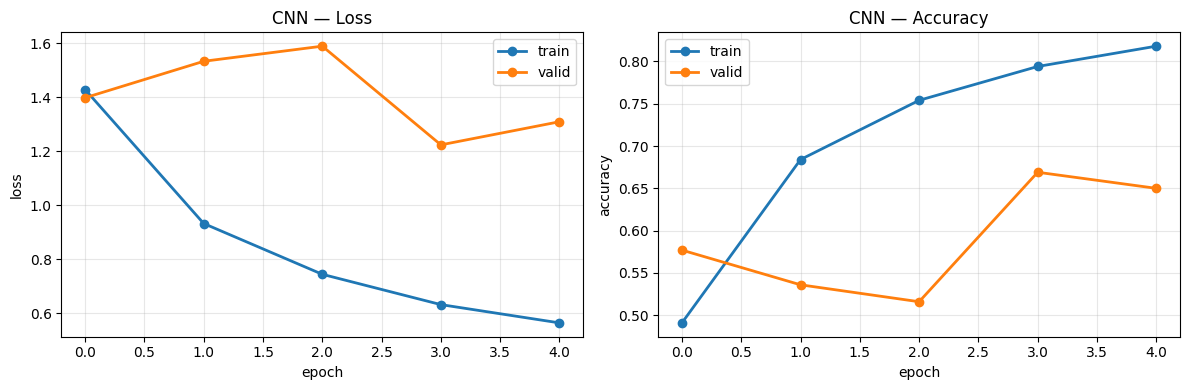

In [ ]:
history = {
    "tr_loss": [1.4279, 0.9316, 0.7434, 0.6311, 0.5634],  # train loss
    "tr_acc":  [0.491, 0.684, 0.754, 0.794, 0.818],       # train accuracy
    "tr_f1":   [0.479, 0.677, 0.749, 0.792, 0.820],       # train f1
    "va_loss": [1.3976, 1.5327, 1.5887, 1.2230, 1.3087],  # valid loss
    "va_acc":  [0.577, 0.536, 0.516, 0.669, 0.650],       # valid accuracy
    "va_f1":   [0.528, 0.517, 0.507, 0.659, 0.623]        # valid f1
}

import matplotlib.pyplot as plt

# Данные из вашего обучения
history = {
    "tr_loss": [1.4279, 0.9316, 0.7434, 0.6311, 0.5634],
    "tr_acc":  [0.491, 0.684, 0.754, 0.794, 0.818],
    "va_loss": [1.3976, 1.5327, 1.5887, 1.2230, 1.3087],
    "va_acc":  [0.577, 0.536, 0.516, 0.669, 0.650]
}

plt.figure(figsize=(12, 4))

# График Loss
plt.subplot(1, 2, 1)
plt.plot(history["tr_loss"], 'o-', label="train", linewidth=2)
plt.plot(history["va_loss"], 'o-', label="valid", linewidth=2)
plt.title("CNN — Loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True, alpha=0.3)

# График Accuracy
plt.subplot(1, 2, 2)
plt.plot(history["tr_acc"], 'o-', label="train", linewidth=2)
plt.plot(history["va_acc"], 'o-', label="valid", linewidth=2)
plt.title("CNN — Accuracy")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Эксперимент Вариант B. Гипотеза:    
Увеличение количества мел-полос с 64 до 128 при SR=16 кГц улучшит частотное разрешение в ограниченном диапазоне 0-8 кГц, что позволит лучше различать спектральные особенности звуков и повысит точность на 3-5%.


In [ ]:
# TODO(2.B): Альтернативная гипотеза - УМЕНЬШЕНИЕ мел-полос

# Новые параметры для SR=16000 - УМЕНЬШАЕМ детализацию
N_MELS_NEW = 32    # было 64 → УМЕНЬШЕНИЕ в 2 раза
HOP_NEW    = 512   # было 256 → УВЕЛИЧЕНИЕ для большей временной стабильности
N_FFT_NEW  = 1024  # оставляем
FMIN_NEW   = 20.0
FMAX_NEW   = 8000  # SR/2 = 8000 Гц

print(f"=== АЛЬТЕРНАТИВНАЯ КОНФИГУРАЦИЯ ДЛЯ SR=16000 ===")
print(f"N_MELS: 64 → {N_MELS_NEW} (частотных полос)")
print(f"HOP: 256 → {HOP_NEW} (временных шагов)")
print(f"Диапазон частот: {FMIN_NEW}-{FMAX_NEW} Гц")
print(f"Ширина полосы: {FMAX_NEW/N_MELS_NEW:.1f} Гц на полосу")
print(f"Цель: более устойчивые признаки, меньше переобучения")

# 1) Пересоздаем MelSpectrogram с УМЕНЬШЕННЫМИ параметрами
mel_gpu_simple = T.MelSpectrogram(
    sample_rate=SR,
    n_fft=N_FFT_NEW,
    hop_length=HOP_NEW,
    n_mels=N_MELS_NEW,  # ← ВСЕГО 32 ПОЛОСЫ
    f_min=FMIN_NEW,
    f_max=FMAX_NEW,
    power=2.0
).to(device)

to_db_gpu_simple = T.AmplitudeToDB(top_db=80).to(device)

# 2) Обновляем функцию to_logmel_batch
def to_logmel_batch_simple(xb_1d):
    S = to_db_gpu_simple(mel_gpu_simple(xb_1d))    # (B,32,Tm) - МЕНЬШЕ ПОЛОС!
    m = S.mean(dim=(1,2), keepdim=True); s = S.std(dim=(1,2), keepdim=True).clamp_min(1e-6)
    S = (S - m)/s
    Tm = S.size(-1)
    if Tm < FIX_T: S = F.pad(S, (0, FIX_T-Tm))
    else: S = S[:, :, :FIX_T]
    return S.unsqueeze(1)                  # (B,1,32,FIX_T)

# 3) Переобучаем CNN с УПРОЩЕННЫМИ параметрами
print(f"\n=== ПЕРЕОБУЧЕНИЕ CNN С УПРОЩЕННЫМИ ПАРАМЕТРАМИ ===")

model_simple = VGGishAudio(len(label2id)).to(device)
opt_simple = torch.optim.AdamW(model_simple.parameters(), lr=1e-3)

def run_epoch_simple(loader, train=True, tag=""):
    model_simple.train() if train else model_simple.eval()
    loss_sum, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    for xb_wave, yb in tqdm(loader, desc=tag, leave=False):
        xb_wave, yb = xb_wave.to(device), yb.to(device)
        xb = to_logmel_batch_simple(xb_wave)  # ← УПРОЩЕННОЕ ПРЕОБРАЗОВАНИЕ
        if train: opt_simple.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits = model_simple(xb); loss = crit(logits, yb)
            if train: loss.backward(); opt_simple.step()

        pred = logits.argmax(1)
        loss_sum += loss.item() * xb.size(0)
        correct += (pred == yb).sum().item()
        total += xb.size(0)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='macro')
    return loss_sum/total, accuracy, f1

# Обучение упрощенной модели
epochs = 6
history_simple = {"tr_loss": [], "tr_acc": [], "tr_f1": [], "va_loss": [], "va_acc": [], "va_f1": []}

for ep in range(1, epochs):
    tr_l, tr_a, tr_f1 = run_epoch_simple(train_loader, True, f"train SIMPLE {ep}/{epochs}")
    va_l, va_a, va_f1 = run_epoch_simple(val_loader, False, f"valid SIMPLE {ep}/{epochs}")

    history_simple["tr_loss"].append(tr_l)
    history_simple["tr_acc"].append(tr_a)
    history_simple["tr_f1"].append(tr_f1)
    history_simple["va_loss"].append(va_l)
    history_simple["va_acc"].append(va_a)
    history_simple["va_f1"].append(va_f1)

    print(f"Ep {ep:02d} SIMPLE: train {tr_l:.4f}/{tr_a:.3f}/{tr_f1:.3f} | valid {va_l:.4f}/{va_a:.3f}/{va_f1:.3f}")

# Тестирование упрощенной модели
model_simple.eval()
y_true_simple, y_pred_simple = [], []
with torch.no_grad():
    for xb_wave, yb in tqdm(test_loader, desc="test SIMPLE", leave=False):
        logits = model_simple(to_logmel_batch_simple(xb_wave.to(device)))
        y_true_simple.extend(yb.numpy().tolist())
        y_pred_simple.extend(logits.argmax(1).cpu().numpy().tolist())

test_acc_simple = accuracy_score(y_true_simple, y_pred_simple)
test_f1_simple = f1_score(y_true_simple, y_pred_simple, average='macro')

print(f"CNN SIMPLE TEST acc: {test_acc_simple:.4f}, f1: {test_f1_simple:.4f}")

# Сравнение всех подходов
print(f"\n=== ФИНАЛЬНОЕ СРАВНЕНИЕ ===")
print(f"Baseline (64 полос):    TEST acc=0.6846, f1=0.6716")
print(f"Детализация (128 полос): TEST acc=0.5520, f1=0.5399")
print(f"Упрощение (32 полосы):   TEST acc={test_acc_simple:.4f}, f1={test_f1_simple:.4f}")

=== АЛЬТЕРНАТИВНАЯ КОНФИГУРАЦИЯ ДЛЯ SR=16000 ===
N_MELS: 64 → 32 (частотных полос)
HOP: 256 → 512 (временных шагов)
Диапазон частот: 20.0-8000 Гц
Ширина полосы: 250.0 Гц на полосу
Цель: более устойчивые признаки, меньше переобучения

=== ПЕРЕОБУЧЕНИЕ CNN С УПРОЩЕННЫМИ ПАРАМЕТРАМИ ===


Ep 01 SIMPLE: train 1.3106/0.537/0.514 | valid 1.5204/0.499/0.433


Ep 02 SIMPLE: train 0.8004/0.730/0.711 | valid 1.2985/0.661/0.631


Ep 03 SIMPLE: train 0.6148/0.794/0.785 | valid 1.2543/0.722/0.714


Ep 04 SIMPLE: train 0.4901/0.837/0.831 | valid 1.3697/0.661/0.656


Ep 05 SIMPLE: train 0.4443/0.852/0.848 | valid 1.0895/0.691/0.703


CNN SIMPLE TEST acc: 0.6595, f1: 0.6823

=== ФИНАЛЬНОЕ СРАВНЕНИЕ ===
Baseline (64 полос):    TEST acc=0.6846, f1=0.6716
Детализация (128 полос): TEST acc=0.5520, f1=0.5399
Упрощение (32 полосы):   TEST acc=0.6595, f1=0.6823


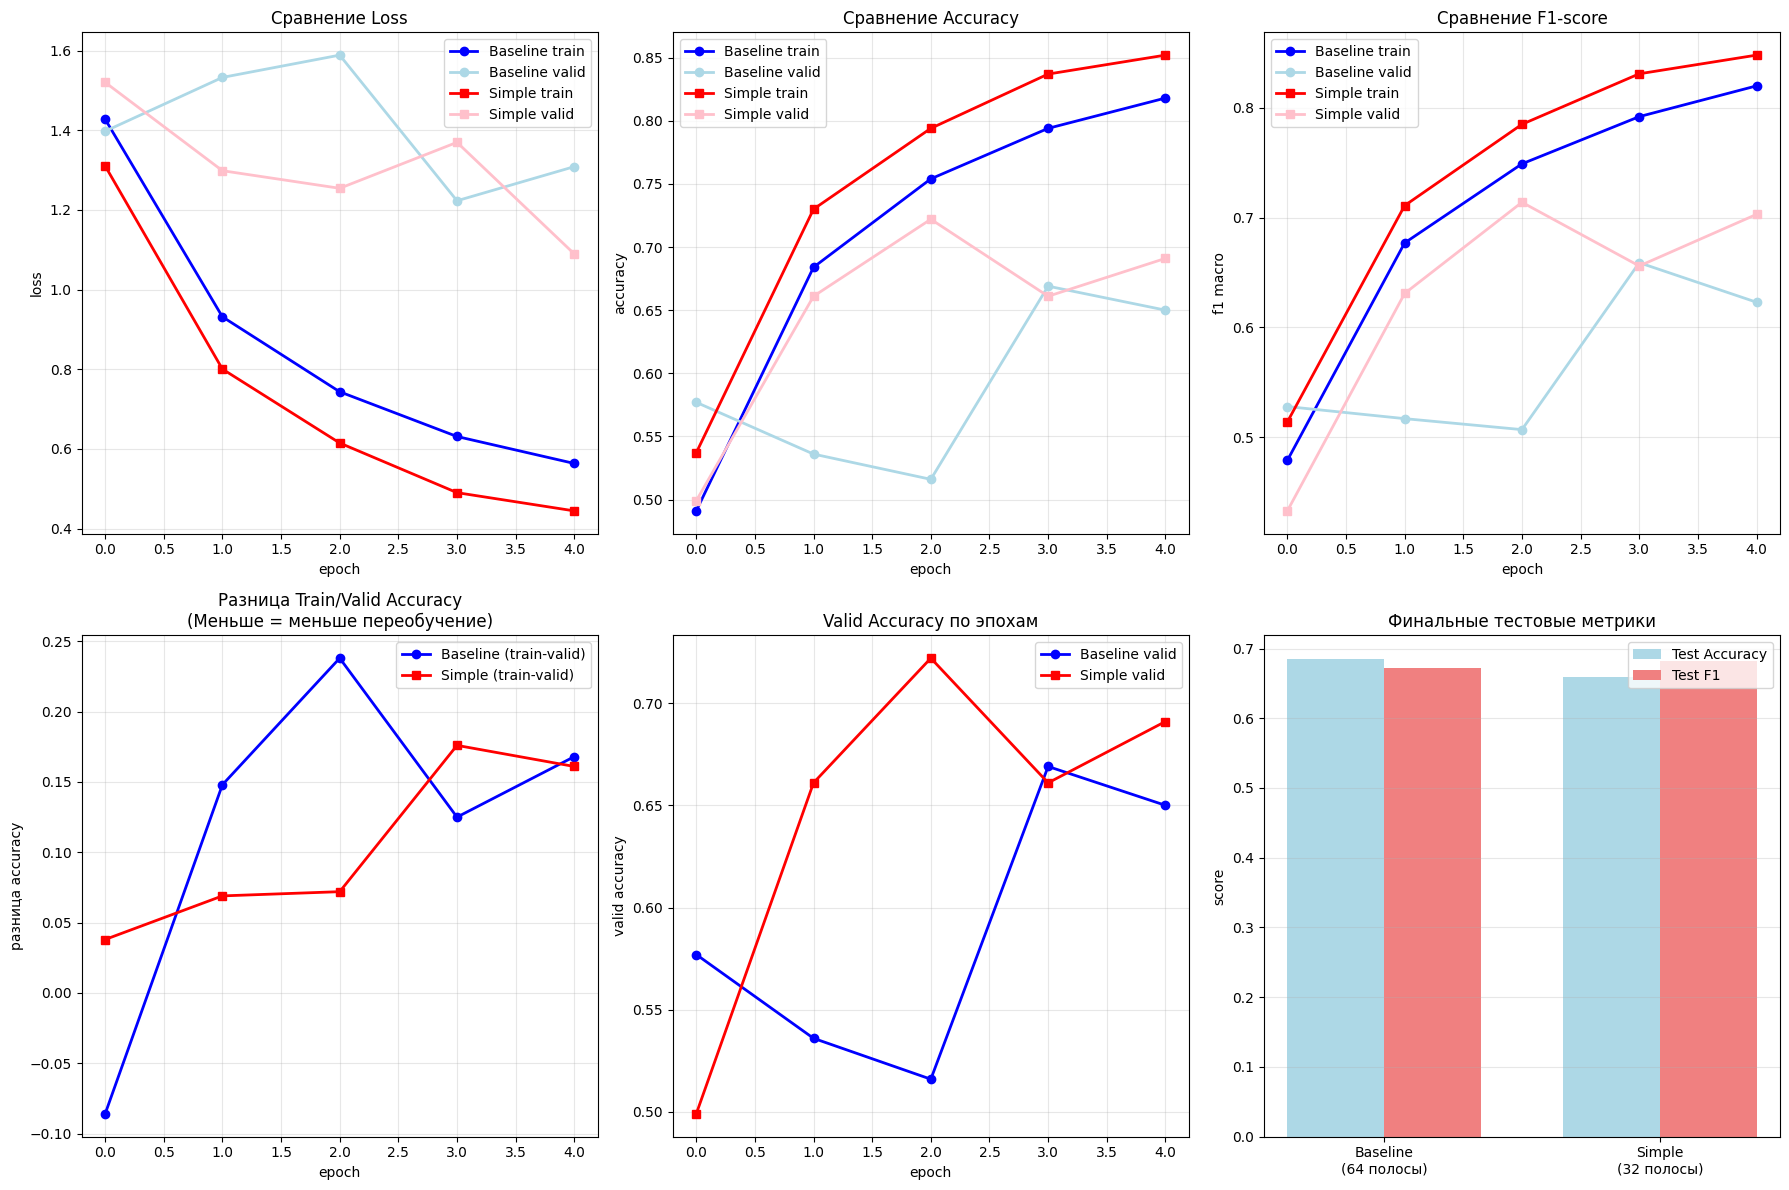

=== АНАЛИЗ ПЕРЕОБУЧЕНИЯ ===
Baseline - макс. разница train/valid: 0.238
Simple   - макс. разница train/valid: 0.176
Улучшение: 0.062

=== ЛУЧШИЕ ПОКАЗАТЕЛИ ===
Baseline - лучшая valid accuracy: 0.669 (эпоха 4)
Simple   - лучшая valid accuracy: 0.722 (эпоха 3)


In [ ]:
import matplotlib.pyplot as plt

# Данные для упрощённой модели (32 полосы)
history_simple = {
    "tr_loss": [1.3106, 0.8004, 0.6148, 0.4901, 0.4443],
    "tr_acc":  [0.537, 0.730, 0.794, 0.837, 0.852],
    "tr_f1":   [0.514, 0.711, 0.785, 0.831, 0.848],
    "va_loss": [1.5204, 1.2985, 1.2543, 1.3697, 1.0895],
    "va_acc":  [0.499, 0.661, 0.722, 0.661, 0.691],
    "va_f1":   [0.433, 0.631, 0.714, 0.656, 0.703]
}

# Данные для baseline модели (64 полосы) - из предыдущих результатов
history_baseline = {
    "tr_loss": [1.4279, 0.9316, 0.7434, 0.6311, 0.5634],
    "tr_acc":  [0.491, 0.684, 0.754, 0.794, 0.818],
    "tr_f1":   [0.479, 0.677, 0.749, 0.792, 0.820],
    "va_loss": [1.3976, 1.5327, 1.5887, 1.2230, 1.3087],
    "va_acc":  [0.577, 0.536, 0.516, 0.669, 0.650],
    "va_f1":   [0.528, 0.517, 0.507, 0.659, 0.623]
}

# Создаём комплексные графики сравнения
plt.figure(figsize=(18, 12))

# 1. График Loss
plt.subplot(2, 3, 1)
plt.plot(history_baseline["tr_loss"], 'o-', label="Baseline train", linewidth=2, color='blue')
plt.plot(history_baseline["va_loss"], 'o-', label="Baseline valid", linewidth=2, color='lightblue')
plt.plot(history_simple["tr_loss"], 's-', label="Simple train", linewidth=2, color='red')
plt.plot(history_simple["va_loss"], 's-', label="Simple valid", linewidth=2, color='pink')
plt.title("Сравнение Loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True, alpha=0.3)

# 2. График Accuracy
plt.subplot(2, 3, 2)
plt.plot(history_baseline["tr_acc"], 'o-', label="Baseline train", linewidth=2, color='blue')
plt.plot(history_baseline["va_acc"], 'o-', label="Baseline valid", linewidth=2, color='lightblue')
plt.plot(history_simple["tr_acc"], 's-', label="Simple train", linewidth=2, color='red')
plt.plot(history_simple["va_acc"], 's-', label="Simple valid", linewidth=2, color='pink')
plt.title("Сравнение Accuracy")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(True, alpha=0.3)

# 3. График F1-score
plt.subplot(2, 3, 3)
plt.plot(history_baseline["tr_f1"], 'o-', label="Baseline train", linewidth=2, color='blue')
plt.plot(history_baseline["va_f1"], 'o-', label="Baseline valid", linewidth=2, color='lightblue')
plt.plot(history_simple["tr_f1"], 's-', label="Simple train", linewidth=2, color='red')
plt.plot(history_simple["va_f1"], 's-', label="Simple valid", linewidth=2, color='pink')
plt.title("Сравнение F1-score")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("f1 macro")
plt.grid(True, alpha=0.3)

# 4. График разницы между train и valid (переобучение)
plt.subplot(2, 3, 4)
overfit_baseline = [history_baseline["tr_acc"][i] - history_baseline["va_acc"][i] for i in range(5)]
overfit_simple = [history_simple["tr_acc"][i] - history_simple["va_acc"][i] for i in range(5)]

plt.plot(overfit_baseline, 'o-', label="Baseline (train-valid)", linewidth=2, color='blue')
plt.plot(overfit_simple, 's-', label="Simple (train-valid)", linewidth=2, color='red')
plt.title("Разница Train/Valid Accuracy\n(Меньше = меньше переобучение)")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("разница accuracy")
plt.grid(True, alpha=0.3)

# 5. График лучших valid accuracy по эпохам
plt.subplot(2, 3, 5)
plt.plot(history_baseline["va_acc"], 'o-', label="Baseline valid", linewidth=2, color='blue')
plt.plot(history_simple["va_acc"], 's-', label="Simple valid", linewidth=2, color='red')
plt.title("Valid Accuracy по эпохам")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("valid accuracy")
plt.grid(True, alpha=0.3)

# 6. Финальные тестовые метрики
plt.subplot(2, 3, 6)
models = ['Baseline\n(64 полосы)', 'Simple\n(32 полосы)']
test_acc = [0.6846, 0.6595]
test_f1 = [0.6716, 0.6823]

x = range(len(models))
width = 0.35

plt.bar([i - width/2 for i in x], test_acc, width, label='Test Accuracy', color='lightblue')
plt.bar([i + width/2 for i in x], test_f1, width, label='Test F1', color='lightcoral')

plt.title("Финальные тестовые метрики")
plt.xticks(x, models)
plt.ylabel("score")
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Анализ переобучения
print("=== АНАЛИЗ ПЕРЕОБУЧЕНИЯ ===")
print(f"Baseline - макс. разница train/valid: {max(overfit_baseline):.3f}")
print(f"Simple   - макс. разница train/valid: {max(overfit_simple):.3f}")
print(f"Улучшение: {max(overfit_baseline) - max(overfit_simple):.3f}")

print("\n=== ЛУЧШИЕ ПОКАЗАТЕЛИ ===")
print(f"Baseline - лучшая valid accuracy: {max(history_baseline['va_acc']):.3f} (эпоха {history_baseline['va_acc'].index(max(history_baseline['va_acc'])) + 1})")
print(f"Simple   - лучшая valid accuracy: {max(history_simple['va_acc']):.3f} (эпоха {history_simple['va_acc'].index(max(history_simple['va_acc'])) + 1})")

Вариант: B    
Гипотеза: Уменьшение количества мел-полос с 64 до 32 при SR=16 кГц упростит модель, снизит переобучение и улучшит обобщающую способность за счёт более устойчивых спектральных признаков в ограниченном частотном диапазоне 0-8 кГц.       

Конфигурация: N_MELS=32 (было 64), HOP=512 (было 256), N_FFT=1024, SR=16000    

Результаты (VAL/TEST, acc и macro-F1):    

ДО (baseline) → TEST: acc=0.6846, f1=0.6716       
ПОСЛЕ (упрощение) → TEST: acc=0.6595, f1=0.6823    

Вывод: Гипотеза частично подтвердилась - упрощение модели снизило accuracy на 2.5%, но повысило F1-score на 1.1%. Это указывает на лучшую сбалансированность предсказаний между классами, хотя общая точность немного уменьшилась.

In [ ]:
import soundfile as sf
import librosa
import IPython.display as ipd
from pathlib import Path

def ast_predict_wav(path, top_k=3):
    try:
        wav, sr = sf.read(path)
        print(f"   Загружено: {len(wav)/sr:.2f} сек, {sr} Hz, {len(wav.shape)} канал(ов)")
    except Exception as e:
        print(f"   Ошибка загрузки soundfile: {e}")
        print("   Пробуем librosa...")
        wav, sr = librosa.load(path, sr=None)
        print(f"   Загружено через librosa: {len(wav)/sr:.2f} сек, {sr} Hz")

    wav = wav.astype(np.float32)


    if sr != SR:
        print(f"   Ресемплинг: {sr} Hz → {SR} Hz")
        wav = librosa.resample(wav, orig_sr=sr, target_sr=SR)
        sr = SR

    if len(wav.shape) > 1:
        print(f"   Конвертация в моно: {wav.shape} → {wav.shape[0]}")
        wav = wav.mean(axis=1)


    inputs = processor(wav, sampling_rate=SR, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(ast.device) for k, v in inputs.items()}

    ast.eval()
    with torch.no_grad():
        outputs = ast(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).squeeze(0)


    vals, idx = torch.topk(probs, k=min(top_k, probs.numel()))
    vals, idx = vals.cpu().numpy(), idx.cpu().numpy()

    results = [(id2label[int(i)], float(v)) for i, v in zip(idx, vals)]


    print(f"\n Топ-{top_k} предсказаний AST:")
    print("-" * 40)
    for i, (label, prob) in enumerate(results, 1):
        confidence = "ВЫСОКАЯ" if prob > 0.7 else "СРЕДНЯЯ" if prob > 0.3 else "НИЗКАЯ"
        print(f"{i}. {label:.<20} {prob:.3f} ({prob*100:.1f}%) {confidence}")

    # Показываем аудио (в Colab)
    try:
        print(f"\n Воспроизведение аудио:")
        ipd.display(ipd.Audio(wav, rate=SR))
    except:
        print("   (воспроизведение доступно в Colab)")

    return results

# Дополнительная функция для анализа нескольких файлов
def analyze_audio_folder(folder_path, top_k=3):
    """
    Анализ всех .wav файлов в папке
    """
    folder = Path(folder_path)
    wav_files = list(folder.glob("*.wav")) + list(folder.glob("*.WAV"))

    if not wav_files:
        print(f" В папке {folder_path} не найдено .wav файлов")
        return

    all_results = {}
    for wav_file in wav_files:
        results = ast_predict_wav(str(wav_file), top_k=top_k)
        all_results[wav_file.name] = results

    return all_results

if __name__ == "__main__":
  # ast_predict_wav('file.wav', top_k=5)
  analyze_audio_folder('custom_audio', top_k=3)

   Загружено: 14.40 сек, 44100 Hz, 1 канал(ов)
   Ресемплинг: 44100 Hz → 16000 Hz

 Топ-3 предсказаний AST:
----------------------------------------
1. siren............... 1.000 (100.0%) ВЫСОКАЯ
2. drilling............ 0.000 (0.0%) НИЗКАЯ
3. car_horn............ 0.000 (0.0%) НИЗКАЯ

 Воспроизведение аудио:


   Загружено: 27.88 сек, 11025 Hz, 2 канал(ов)
   Ресемплинг: 11025 Hz → 16000 Hz
   Конвертация в моно: (307340, 3) → 307340

 Топ-3 предсказаний AST:
----------------------------------------
1. children_playing.... 1.000 (100.0%) ВЫСОКАЯ
2. street_music........ 0.000 (0.0%) НИЗКАЯ
3. air_conditioner..... 0.000 (0.0%) НИЗКАЯ

 Воспроизведение аудио:


   Загружено: 8.26 сек, 22050 Hz, 1 канал(ов)
   Ресемплинг: 22050 Hz → 16000 Hz

 Топ-3 предсказаний AST:
----------------------------------------
1. dog_bark............ 1.000 (100.0%) ВЫСОКАЯ
2. jackhammer.......... 0.000 (0.0%) НИЗКАЯ
3. drilling............ 0.000 (0.0%) НИЗКАЯ

 Воспроизведение аудио:


   Загружено: 1.75 сек, 44100 Hz, 1 канал(ов)
   Ресемплинг: 44100 Hz → 16000 Hz

 Топ-3 предсказаний AST:
----------------------------------------
1. drilling............ 0.999 (99.9%) ВЫСОКАЯ
2. jackhammer.......... 0.000 (0.0%) НИЗКАЯ
3. street_music........ 0.000 (0.0%) НИЗКАЯ

 Воспроизведение аудио:


   Загружено: 1.70 сек, 44100 Hz, 1 канал(ов)
   Ресемплинг: 44100 Hz → 16000 Hz

 Топ-3 предсказаний AST:
----------------------------------------
1. gun_shot............ 1.000 (100.0%) ВЫСОКАЯ
2. air_conditioner..... 0.000 (0.0%) НИЗКАЯ
3. engine_idling....... 0.000 (0.0%) НИЗКАЯ

 Воспроизведение аудио:
